<center>
<h1><b>Radiation Dose Prediction for Cancer Patients</b></h1>
</center>
Radiation therapy is a common treatment modality for cancer patients, which uses ionizing radiation to kill cancer cells or reduce the size of tumors. However, radiation therapy also poses risks, including potential damage to healthy tissues and organs. Therefore, it is important to accurately predict the radiation dose that a patient will receive during treatment to ensure the best possible outcomes.

The goal of this project is to develop a model that can predict the radiation dose a cancer patient will receive during radiation therapy. This model can help radiation oncologists optimize treatment plans and minimize the risk of adverse side effects.

In this notebook, we will train a deep learning model that performs radiation dose prediction using a 2D patient's CT scan, binary masks of the targeted dose area and masks of organs involved in the treatment. 

In [55]:
# torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as T

# plots
import matplotlib.pyplot as plt

# usual 
import numpy as np
from tqdm import tqdm
import random

# system
import os
import sys
import time

In [2]:
# get folder containing models and utils
!gdown --folder https://drive.google.com/drive/folders/1zZo_zJGXgYbH95iA8MZvr-dzRpxC5Abw?usp=share_link -O /content/src

Retrieving folder list
Processing file 1E2UV_waEDup85CUONpWHwHzrjB4bJ83n augmentation.py
Processing file 17AsDUK_XuBFcloJj9ObBimfqS1i2waj2 models.py
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1E2UV_waEDup85CUONpWHwHzrjB4bJ83n
To: /content/src/augmentation.py
100% 2.39k/2.39k [00:00<00:00, 4.85MB/s]
Downloading...
From: https://drive.google.com/uc?id=17AsDUK_XuBFcloJj9ObBimfqS1i2waj2
To: /content/src/models.py
100% 23.4k/23.4k [00:00<00:00, 41.3MB/s]
Download completed


In [3]:
# add folder to system abs path 
sys.path.append("/content/src/")

In [ ]:
# get folder containing the checkpoints
!gdown --folder https://drive.google.com/drive/folders/1ZV7lD0pvxjoOBKG59iRZBe1Ju9Yuu5Vq?usp=share_link -O /content/checkpoints

# 0. Fetch and create the dataset

**Dataset for the competition**



* Comes from the Open-KBP challenge.
* Modified for our class into a 2D dataset.
* Content of the folder of a sample:
  * Structural masks: binary masks of the 10 organs involved in the treatment
    * 10 x 128 x 128 volume
  * Possible dose mask: binary mask of where there irradiation is allowed
    * 128 x 128 image
  * Dose: ground-truth dose
    * 128 x 128 image
  * CT: scan of the patient
    * 128 x 128 image


In [4]:
# get the dataset from the git repo
!git clone https://github.com/soniamartinot/MVA-Dose-Prediction.git

Cloning into 'MVA-Dose-Prediction'...
remote: Enumerating objects: 38724, done.
remote: Total 38724 (delta 0), reused 0 (delta 0), pack-reused 38724
Receiving objects: 100% (38724/38724), 77.02 MiB | 29.86 MiB/s, done.
Resolving deltas: 100% (30603/30603), done.
Updating files: 100% (39600/39600), done.


In [5]:
!ls MVA-Dose-Prediction/test/sample_10000/

ct.npy	possible_dose_mask.npy	structure_masks.npy


Let's discover the content of one folder of data.

In [56]:
root = "MVA-Dose-Prediction/"
mode = ['train', 'validation', 'test']

Exception ignored in: <function tqdm.__del__ at 0x7f648842e8b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/usr/local/lib/python3.9/dist-packages/tqdm/std.py", line 1274, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'


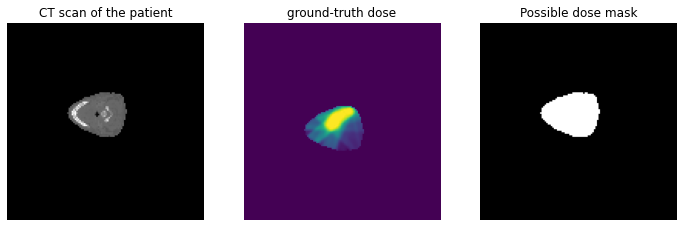

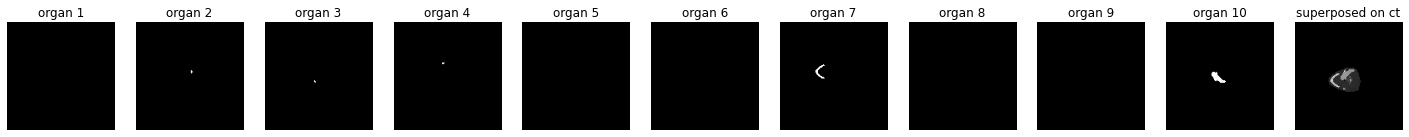

In [57]:
sample = os.listdir(os.path.join(root,mode[0]))[np.random.randint(7800)]

# ct
ct = np.load(os.path.join(root, mode[0], sample, 'ct.npy'))

# dose 
dose = np.load(os.path.join(root, mode[0], sample, 'dose.npy'))

# possible dose mask
dose_mask = np.load(os.path.join(root, mode[0], sample, 'possible_dose_mask.npy'))

# structure masks
structural_mask = np.load(os.path.join(root, mode[0], sample, 'structure_masks.npy'))

# plot the examples
plt.figure(figsize=(12, 7))

plt.subplot(1, 3, 1)
plt.imshow(ct, cmap='gray', origin='lower')
plt.title("CT scan of the patient")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(dose)
plt.title("ground-truth dose")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(dose_mask, cmap='gray', origin='lower')
plt.title("Possible dose mask")
plt.axis('off')

plt.figure(figsize=(25, 9))
organs = ct/ct.max()
for i in range(10):
  organs += structural_mask[i,:,:]
  plt.subplot(1, 11, i+1)
  plt.imshow(structural_mask[i,:,:], cmap='gray', origin='lower')
  plt.title(f"organ {i+1}")
  plt.axis('off')

plt.subplot(1, 11, 11)
plt.imshow(organs, cmap='gray')
plt.title("superposed on ct")
plt.axis('off')

plt.show()

In [58]:
class RadiationDataset(Dataset):
  """ Dataset utility class.
    Args:
        root: (str) Path of the folder with all the images.
        mode : {'train', 'validation' , 'test'} Part of the dataset that is loaded.
        tranform : applied transform on the four components if any
  """

  def __init__(self, root, mode='train', transform=None):

    super(RadiationDataset, self).__init__()
    self.root = os.path.join(root, mode)
    self.mode = mode
    self.transform = transform

    # get the samples ids
    self.samples = sorted(os.listdir(self.root))

    imgs = []
    for sample in self.samples:
      
      # no ground-truth component 
      if mode == 'test': 
        imgs.append((os.path.join(self.root, sample, 'ct.npy'),
                     None,
                     os.path.join(self.root, sample, 'possible_dose_mask.npy'),
                     os.path.join(self.root, sample, 'structure_masks.npy')))
        
      else:
        imgs.append((os.path.join(self.root, sample, 'ct.npy'),
                      os.path.join(self.root, sample, 'dose.npy'),
                      os.path.join(self.root, sample, 'possible_dose_mask.npy'),
                      os.path.join(self.root, sample, 'structure_masks.npy')))

    self.imgs = imgs

  def __getitem__(self, idx):

    # get the item paths
    ct_path, dose_path, dose_mask_path, structure_masks_path = self.imgs[idx]

    # get the current sample components
    ct = np.load(ct_path)
    ct = torch.tensor(ct, dtype=torch.float32)
    ct /= ct.max(1, keepdim=True)[0] + 1e-16 # scale values to range in [0,1]

    dose_mask = np.load(dose_mask_path) # values in {0, 1}
    structure_masks = np.load(structure_masks_path) # values in {0, 1}
    if self.mode != 'test': 
      dose = torch.tensor(np.load(dose_path), dtype=torch.float32)
    else:
      dose = []
    
    # join the organs in one single image 
    #structure_masks = structure_masks.sum(axis=0) 

    data = torch.concatenate([ct.unsqueeze(0),
                              torch.tensor(dose_mask, dtype=torch.float32).unsqueeze(0),
                              #torch.tensor(structure_masks, dtype=torch.float32).unsqueeze(0) + ct.unsqueeze(0)], axis=0)
                              torch.tensor(structure_masks, dtype=torch.float32)], axis=0)
    
    
    sample = (data, dose)
            
    # Apply data transformation
    if self.transform:
      data, dose = self.transform(sample)
    
    return data, dose

  def __len__(self):
    return len(self.imgs)

if __name__ == '__main__':
    train = RadiationDataset(root, 'train')
    valid = RadiationDataset(root, 'validation')
    test = RadiationDataset(root, 'test')
    print(f"The training set contains {len(train)} samples.")
    print(f"The validation set contains {len(valid)} samples.")
    print(f"The test set contains {len(test)} samples.")

The training set contains 7800 samples.
The validation set contains 1200 samples.
The test set contains 1200 samples.


In [59]:
train[0][0].shape

torch.Size([12, 128, 128])

Let's apply affine data augmentation to assess its effect on the original data. 

In [60]:
from augmentation import RandomAffineTransform, RandomRotation90, GaussianBlur

In [61]:
# create transforms
affine_transformation = torchvision.transforms.Compose([RandomAffineTransform(), RandomRotation90()])
blur_transformation = torchvision.transforms.Compose([GaussianBlur()])

aug_affine = RadiationDataset(root, 'train', transform=affine_transformation)
aug_blur = RadiationDataset(root, 'train', transform=blur_transformation)

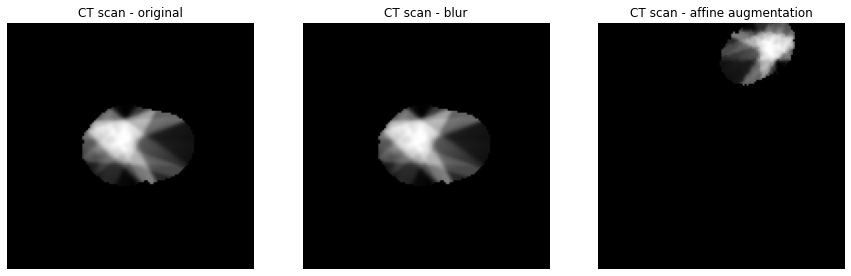

In [62]:
plt.figure(figsize=(15,7))

plt.subplot(1, 3, 1)
plt.imshow(train[0][1], cmap='gray', origin='lower')
plt.title("CT scan - original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(aug_blur[0][1], cmap='gray', origin='lower')
plt.title("CT scan - blur")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(aug_affine[0][1], cmap='gray', origin='lower')
plt.title("CT scan - affine augmentation")
plt.axis("off")
plt.show()

# 1. Models
The file src/models.py contains all the models that were used to run experiments in this project. In this notebook, we are interested in the UNet, the Attention UNet and the DCNN models.

In [63]:
from models import Model, UNet, AttU_Net

In [64]:
dcnn = Model(in_ch=12, out_ch=1, list_ch=[-1, 32, 64, 128, 256])
unet = UNet(in_channels=12, out_channels=1)
att_unet = AttU_Net(img_ch=12,output_ch=1)

# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !


Let's test the models on random data to make sure the dimensions are correct

In [65]:
x = torch.rand((1, 12, 128, 128))
y = dcnn(x)
print(y.shape)

torch.Size([1, 1, 128, 128])


In [66]:
x = torch.rand((1, 12, 128, 128))
y = unet(x)
print(y.shape)

torch.Size([1, 1, 128, 128])


In [67]:
x = torch.rand((1, 12, 128, 128))
y = att_unet(x)
print(y.shape)

torch.Size([1, 1, 128, 128])


In [68]:
# Count the number of trainable parameters
num_params = sum(p.numel() for p in dcnn.parameters() if p.requires_grad)
print(f"Number of trainable parameters in DCNN: {num_params}")

num_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print(f"Number of trainable parameters in UNet: {num_params}")

num_params = sum(p.numel() for p in att_unet.parameters() if p.requires_grad)
print(f"Number of trainable parameters in Att_UNet: {num_params}")

Number of trainable parameters in DCNN: 11182465
Number of trainable parameters in UNet: 18121153
Number of trainable parameters in Att_UNet: 34883757


# 2. Train and evaluate functions
Note that the default inputs to the models are the concatenated 12 channels (ct scan + dose mask + 10 organs). If you want to train models on less or customized inputs, please change the "Inputs" lines in the train and evaluation functions accordingly.

In [69]:
EXPERIMENT = 'experiments' 
if not os.path.isdir(EXPERIMENT):
      os.makedirs(EXPERIMENT)
        

def train(model, optimizer, scheduler, criterion, train_loader, val_loader, n_epochs):

  # ----------
  #  Training
  # ----------

  for epoch in range(n_epochs):
    model.train()

    epoch_time_sum, epoch_loss_sum = [], []
    epoch_start = time.time()

    for data, label in tqdm(train_loader):

        batch_start = time.time()

        # Inputs
        data = data.float().cuda()

        # Groud-truth
        label = label.float().cuda()

        # Remove stored gradients
        optimizer.zero_grad()

        # predict radiation dose image 
        pred_dose = model(data)

        # Compute the corresponding loss
        loss = criterion(pred_dose.squeeze(1), label) 

        # Compute the gradient and perform one optimization step
        loss.backward()
        optimizer.step()
        
    
    #print("lr", optimizer.param_groups[0]['lr'])    
    scheduler.step()
        
    # --------------
    #  Log Progress
    # --------------

    # Compute elapsed time
    epoch_loss_sum += [loss.item()]
    average_loss = np.mean(epoch_loss_sum)
          
    validation_loss = evaluate(model, criterion, val_loader)
    epoch_time = time.time() - epoch_start

    if epoch != 0:
        # checkpoint
        if validation_loss <= min(history['val_loss']):
          model_file = os.path.join(EXPERIMENT, 'best_model.pth')
          torch.save(model.state_dict(), model_file)
          print("model saved at ", model_file)

    history['train_loss'] += [average_loss]
    history['val_loss'] += [validation_loss]
    
    print(f'Epoch {epoch+1}/{n_epochs} : training loss = {average_loss}.  validation loss = {validation_loss}. epoch time = {epoch_time}')

In [70]:
def evaluate(model, criterion, val_loader):

    # ----------
    #  Evaluating
    # ----------
    epoch_loss_sum = []
    with torch.no_grad():   # Disable gradient computation (faster and saves memory)
        model.eval()
        for data, label in tqdm(val_loader):

            # Inputs
            data = data.float().cuda()

            # Groud-truth
            label = label.float().cuda()

            # predict radiation dose image 
            pred_dose = model(data)
            #pred_dose = pred_dose * dose_mask

            # Compute the corresponding loss
            loss = criterion(pred_dose.squeeze(1), label) 

            epoch_loss_sum += [loss.item()]

        average_loss = np.mean(epoch_loss_sum)

    
    # Plot the last 5 inference examples
    fig, axs = plt.subplots(2, 5, figsize=(15, 9))
    for i in range(5):
        axs[0,i].imshow(pred_dose[i].squeeze().cpu().numpy(), cmap='gray')
        axs[0,i].set_title(f'prediction {i+1}')
        axs[0,i].axis('off')

        axs[1,i].imshow(label[i].squeeze().cpu().numpy(), cmap='gray')
        axs[1,i].set_title(f'gt {i+1}')
        axs[1,i].axis('off')

    plt.show()
      
    return average_loss

# Instanciation

In this section, you can choose one of the models presented above and train it using a set of augmentation functions.

In [71]:
# hyperpaarmeters
learning_rate = 4*1e-3
n_epochs = 60
batch_size = 32

# model history
history = {'train_loss' : [],
            'val_loss' : []}

In [72]:
# create transforms
transforms_list = [RandomAffineTransform(degrees=0), RandomRotation90()] #, GaussianBlur()]
transformation = torchvision.transforms.Compose(transforms_list)

# create datasets
train_dataset = RadiationDataset(root=root, mode='train', transform=transformation)
val_dataset = RadiationDataset(root=root, mode='validation', transform=None)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True,
                          drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True,
                          drop_last=True)

here, we will train the DCNN model.

In [73]:
model = Model(in_ch=12, out_ch=1, list_ch=[-1, 32, 64, 128, 256]) # Create model
model = nn.DataParallel(model)
model.cuda() # move model to GPU
print()

# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !



In [74]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
train(model, optimizer, scheduler, criterion, train_loader, val_loader, n_epochs)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.plot(np.arange(n_epochs), history['train_loss'], label='train_loss')
plt.plot(np.arange(n_epochs), history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('MAE loss')
plt.legend()
plt.show()

# Inference for submissions

In [ ]:
submission = 'submission' 
if not os.path.isdir(submission):
      os.makedirs(submission)
        
def predict(model, test_loader, saving_path, verbose=True):

    file_names = test_loader.dataset.samples
    cnt = 0
    
    for idx, (data, _) in enumerate(test_loader):
        
        data = data.float().cuda()
        dose_mask = data[:,1,:,:].unsqueeze(1)

        # predict radiation dose image 
        pred_dose = model(data)
        pred_dose = pred_dose * dose_mask
        
        # create prediction file
        pred_dose = pred_dose.detach().squeeze().cpu().numpy()
        file_name = os.path.join(saving_path, file_names[idx])
        np.save(file_name, pred_dose)
        
        if verbose and (cnt <= 5):
            # Plot the first 5 inference examples
            plt.imshow(pred_dose, cmap='gray')
            plt.title(f'prediction {idx+1}')
            plt.axis('off')
            cnt += 1
            plt.show()

In [ ]:
# instanciate model
model = Model(in_ch=12, out_ch=1, list_ch=[-1, 32, 64, 128, 256])
model = nn.DataParallel(model)
model.cuda() 

# load checkpoints weights
checkpoint = torch.load('/content/checkpoints/best_model.pth')

# copy weights to instanciated model
model.load_state_dict(checkpoint)

# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !


<All keys matched successfully>

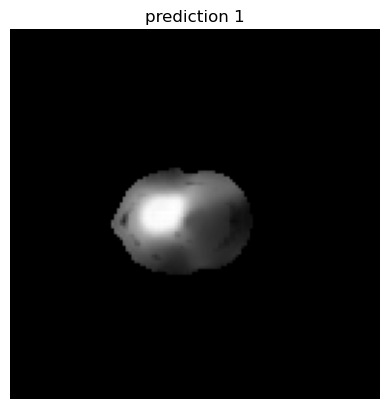

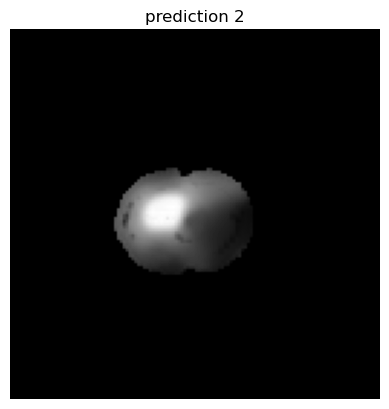

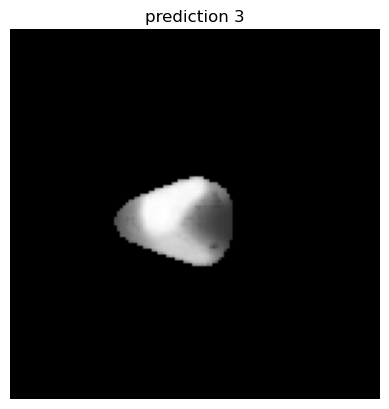

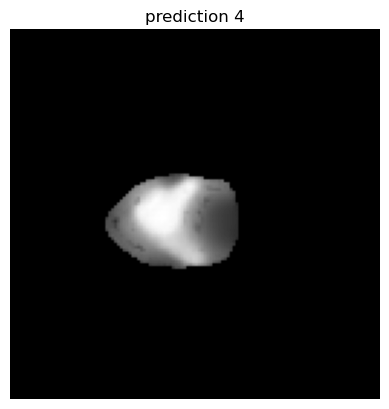

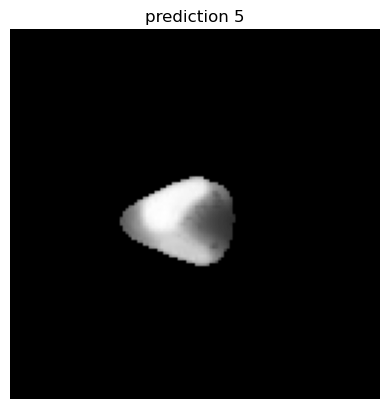

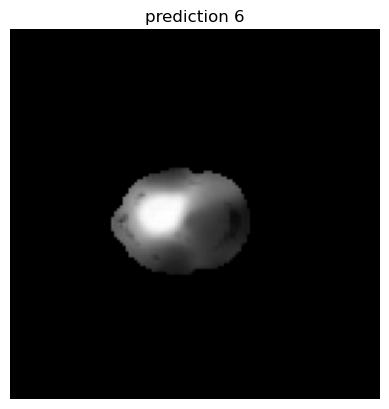

In [ ]:
# create testdataset 
testdataset = RadiationDataset(root, 'test')
# create testloader
test_loader = DataLoader(testdataset, 1, shuffle=False)

# make predictions
predict(model, test_loader, submission, verbose=True)

In [ ]:
import shutil
shutil.make_archive("/content/submission", 'zip', "/content/submission")